<a href="https://colab.research.google.com/github/aditiseshadricodes/PythonFinance/blob/main/ForexPairAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Analysis of EUR/USD, GBP/USD and USD/JPY pairs using yfinance, pandas, mathplotlib/plotly and other python libraries. The purpose of this file is to explore
#Forex Data and show my skills in analyzing this data. I am choosing 1 year of daily data for the 3 forex pairs. The timezone chosen is UTC. I chose
#yfinance for quick prototyping and because it has daily data.
!pip install yfinance alpha_vantage plotly --quiet


I have installed wrapper for YahooFinance API(yfinance), Alpha_vantage class for Forex Data and plotly for interactive data visualizations and used quiet to keep my notebook clean. I am importing os for file handling, pandas for data processing, numpy for nuerical operations, yfinance for historical forex data and datetime and timezone for timestamping and metadata tracking.

In [3]:
# Imports - libraries imported
import os
import pandas as pd
import numpy as np
import yfinance as yf
from alpha_vantage.foreignexchange import ForeignExchange
from datetime import datetime, timezone

# Parameters - used for this analysis
PAIRS = ["EURUSD=X", "GBPUSD=X", "USDJPY=X"]   # yfinance tickers for daily
START = "2024-01-01"
END   = "2025-09-30"
OUTDIR = "data"
os.makedirs(OUTDIR, exist_ok=True)

In [4]:
#Creating a daily downloading data function
def daily_data_download_yf(pair, start, end, outdir):
  df = yf.download(pair, start,end, progress=False)
  df.index = df.index.tz_localize(None)#removing tz info for consistency
  fname=f"{outdir}/{pair.replace('=','')}_daily.csv"
  df.to_csv(fname) #downloading csv data storage
  return df #keeping df for immediate use

In [20]:
ALPHA_KEY="D8FQLHUYB1R8IG0R"

In [6]:
df_eur = daily_data_download_yf("EURUSD=X",START,END,OUTDIR)
df_gbp = daily_data_download_yf("GBPUSD=X",START,END,OUTDIR)
df_jpy = daily_data_download_yf("USDJPY=X",START,END,OUTDIR)
#All 3 datasets kept ready and dataframes ready too.
print(df_eur.tail(5))
print(df_gbp.tail(5))
print(df_jpy.tail(5))
#last fe rows printed

/tmp/ipython-input-657633237.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(pair, start,end, progress=False)
/tmp/ipython-input-657633237.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(pair, start,end, progress=False)
/tmp/ipython-input-657633237.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(pair, start,end, progress=False)


Price          Close      High       Low      Open   Volume
Ticker      EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X EURUSD=X
Date                                                       
2025-09-23  1.180108  1.182005  1.178175  1.180108        0
2025-09-24  1.181447  1.181656  1.173131  1.181447        0
2025-09-25  1.174467  1.175433  1.166793  1.174467        0
2025-09-26  1.166276  1.170220  1.165936  1.166276        0
2025-09-29  1.170823  1.175489  1.170535  1.170823        0
Price          Close      High       Low      Open   Volume
Ticker      GBPUSD=X  GBPUSD=X  GBPUSD=X  GBPUSD=X GBPUSD=X
Date                                                       
2025-09-23  1.351497  1.353601  1.349073  1.351388        0
2025-09-24  1.352448  1.352612  1.342877  1.352612        0
2025-09-25  1.345240  1.346620  1.334241  1.345008        0
2025-09-26  1.333653  1.341382  1.333138  1.333511        0
2025-09-29  1.340824  1.345605  1.340770  1.340770        0
Price            Close        High      

In [7]:
#Metadata for the daily data.
import json

def save_metadata(pair, source, start, end, outdir):
    meta = {
        "pair": pair,
        "source": source,
        "start": start,
        "end": end,
        "downloaded_at_utc": datetime.now(timezone.utc).isoformat()
    }
    fname = f"{outdir}/{pair.replace('/','')}_meta.json"
    with open(fname, "w") as f:
        json.dump(meta, f, indent=2)

save_metadata("EUR/USD", "yfinance", START, END, OUTDIR)
save_metadata("GBP/USD", "yfinance", START, END, OUTDIR)
save_metadata("USD/JPY", "yfinance", START, END, OUTDIR)


This section is for the daily data. Now, let's work on intraday data.

In [10]:
OUTDIR = "data_alpha"
os.makedirs(OUTDIR, exist_ok=True)
#New directory for Intradaycsv files

In [21]:
fx = ForeignExchange(key=ALPHA_KEY, output_format='pandas')
#Data is returned as Pandas DataFrame

In [30]:
import time
def download_intraday_fx(from_symbol,to_symbol,interval,outdir):
  data,_=fx.get_currency_exchange_intraday(from_symbol=from_symbol,to_symbol=to_symbol,interval=interval,outputsize='compact')
  data.index=data.index.tz_localize(None)
  data.columns=['Open','High','Low','Close']
  fname=f"{outdir}/{from_symbol}{to_symbol}_{interval}.csv"
  data.to_csv(fname)
  time.sleep(120)
  return data


In [32]:
#creating intra_day datasets
#df_int_gbp=download_intraday_fx("GBP","USD","60min",OUTDIR)
#df_int_jpy=download_intraday_fx("USD","JPY","60min",OUTDIR)
#printing the last 5 records of each dataframe
#print(df_int_eur.tail(5))
#print(df_int_gbp.tail(5))
#print(df_int_jpy.tail(5))

Now, The data will be processed and loaded using chunking for memory efficient processing.

In [54]:
def process_chunked_csv(filepath, chunk_size=1000):
    chunks = []
    for chunk in pd.read_csv(filepath, chunksize=chunk_size, parse_dates=True, index_col=0):
        # Convert 'Close' column to numeric, coercing errors to NaN
        chunk['Close'] = pd.to_numeric(chunk['Close'], errors='coerce')
        chunk.dropna(inplace=True)
        chunk['Return'] = chunk['Close'].pct_change()
        chunk['Volatility'] = chunk['Return'].rolling(window=10).std()
        chunks.append(chunk)
    df_full = pd.concat(chunks)
    df_full.index = pd.to_datetime(df_full.index) # Ensure index is datetime objects
    return df_full

In [56]:
#For all 3 pairs
df_eur = process_chunked_csv("data/EURUSDX_daily.csv")
df_gbp = process_chunked_csv("data/GBPUSDX_daily.csv")
df_jpy = process_chunked_csv("data/USDJPYX_daily.csv")

/tmp/ipython-input-1446882338.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  for chunk in pd.read_csv(filepath, chunksize=chunk_size, parse_dates=True, index_col=0):
/tmp/ipython-input-1446882338.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  for chunk in pd.read_csv(filepath, chunksize=chunk_size, parse_dates=True, index_col=0):
/tmp/ipython-input-1446882338.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  for chunk in pd.read_csv(filepath, chunksize=chunk_size, parse_dates=True, index_col=0):


In [57]:
df_eur_reset = df_eur.reset_index()
df_gbp_reset = df_gbp.reset_index()
df_jpy_reset = df_jpy.reset_index()


In [58]:
df_eur.to_csv("data/EURUSDX_daily_cleaned.csv")
df_gbp.to_csv("data/GBPUSDX_daily_cleaned.csv")
df_jpy.to_csv("data/USDJPYX_daily_cleaned.csv")


In [59]:
print(df_eur.tail(5))
print(df_gbp.tail(5))
print(df_jpy.tail(5))

               Close                High                 Low  \
Price                                                          
2025-09-23  1.180108  1.1820051670074463   1.178175449371338   
2025-09-24  1.181447  1.1816558837890625  1.1731306314468384   
2025-09-25  1.174467  1.1754333972930908  1.1667931079864502   
2025-09-26  1.166276  1.1702202558517456    1.16593599319458   
2025-09-29  1.170823  1.1754887104034424  1.1705353260040283   

                          Open Volume    Return  Volatility  
Price                                                        
2025-09-23  1.1801080703735352      0  0.005464    0.004793  
2025-09-24  1.1814465522766113      0  0.001134    0.004318  
2025-09-25  1.1744670867919922      0 -0.005908    0.004838  
2025-09-26   1.166275978088379      0 -0.006974    0.005268  
2025-09-29   1.170823097229004      0  0.003899    0.005456  
               Close                High                 Low  \
Price                                                

Now, Exploratory Data Analysis(EDA) is to be done.

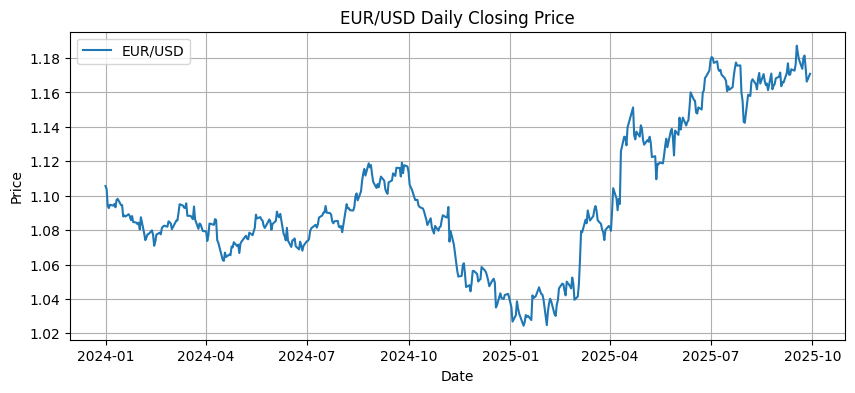

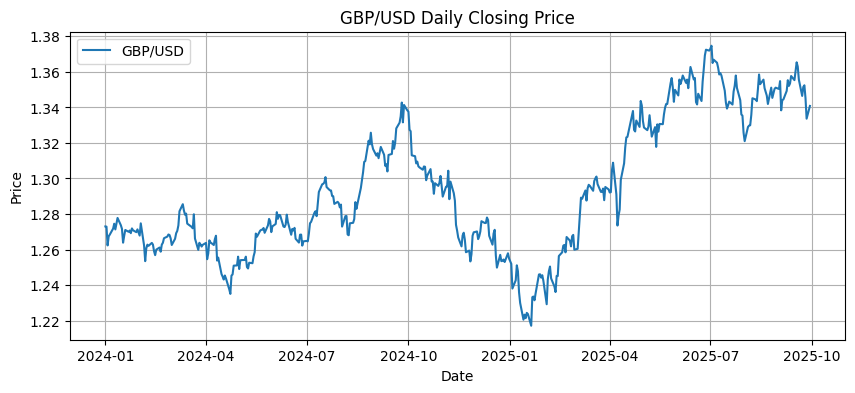

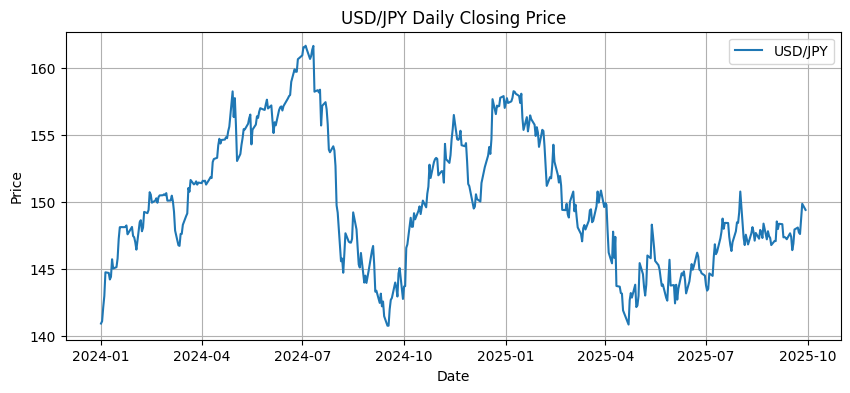

In [60]:
import matplotlib.pyplot as plt
import plotly.express as px

# EUR/USD closing price
plt.figure(figsize=(10, 4))
plt.plot(df_eur['Close'], label='EUR/USD')
plt.title('EUR/USD Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 4))
plt.plot(df_gbp['Close'], label='GBP/USD')
plt.title('GBP/USD Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 4))
plt.plot(df_jpy['Close'], label='USD/JPY')
plt.title('USD/JPY Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


This set of charts is the Visualization of Price trends. This helps spot trends, reversals and macro shifts.
The visualization of returns is next. This highlights volatility and direction. Spikes could be related to major news or events.

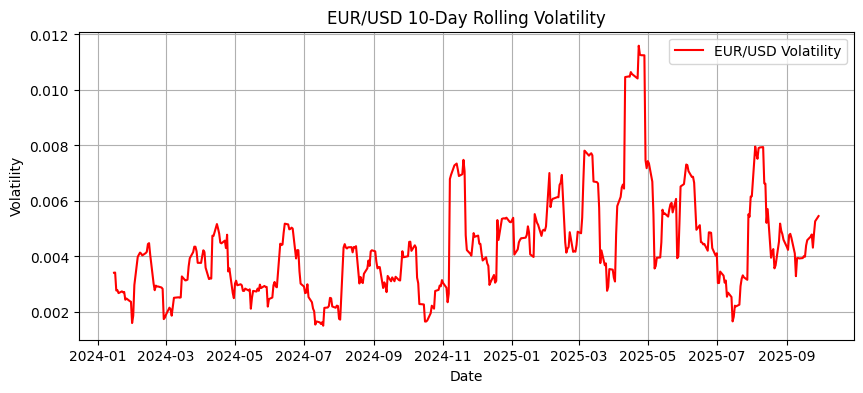

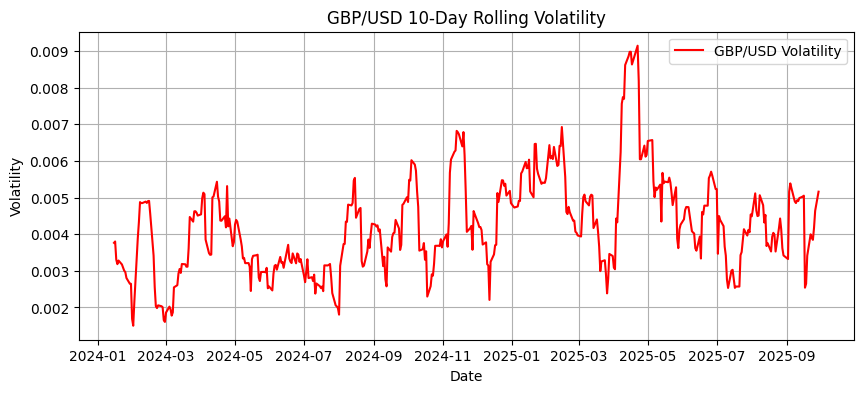

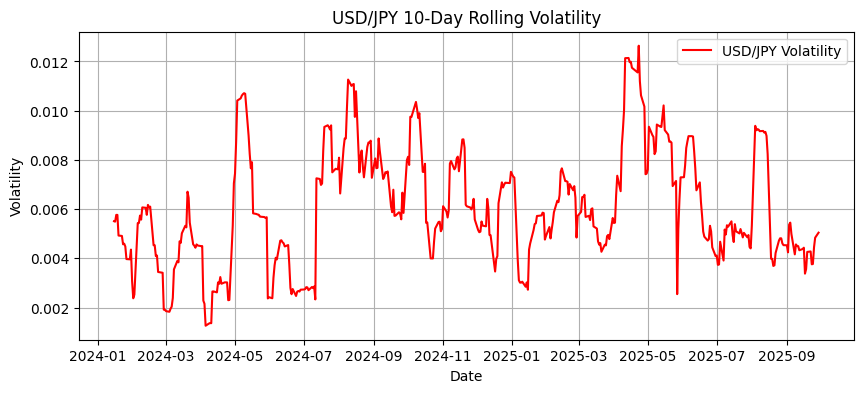

In [61]:
plt.figure(figsize=(10, 4))
plt.plot(df_eur['Volatility'], label='EUR/USD Volatility', color='red')
plt.title('EUR/USD 10-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 4))
plt.plot(df_gbp['Volatility'], label='GBP/USD Volatility', color='red')
plt.title('GBP/USD 10-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 4))
plt.plot(df_jpy['Volatility'], label='USD/JPY Volatility', color='red')
plt.title('USD/JPY 10-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


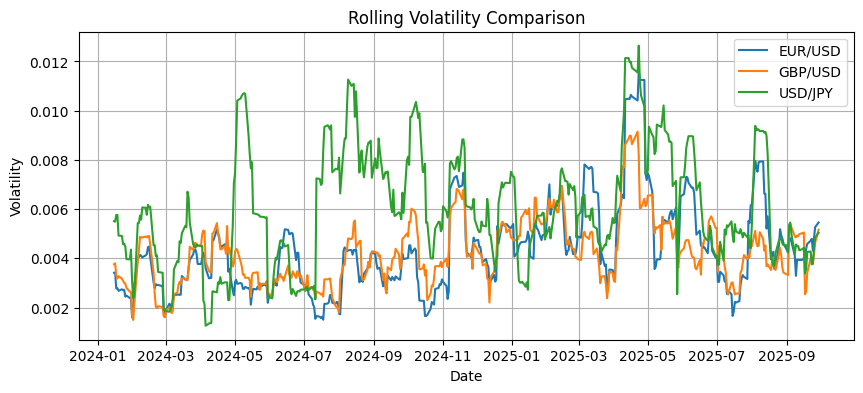

In [62]:
plt.figure(figsize=(10, 4))
plt.plot(df_eur['Volatility'], label='EUR/USD')
plt.plot(df_gbp['Volatility'], label='GBP/USD')
plt.plot(df_jpy['Volatility'], label='USD/JPY')
plt.title('Rolling Volatility Comparison')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()
#Reveals which pair is more volatile over time.

#Useful for risk-adjusted strategy design.

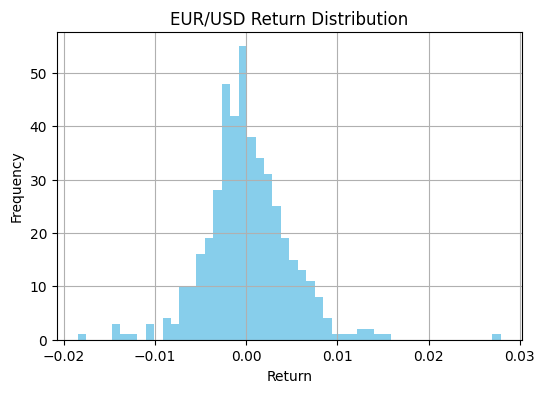

In [63]:
plt.figure(figsize=(6, 4))
df_eur['Return'].hist(bins=50, color='skyblue')
plt.title('EUR/USD Return Distribution')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


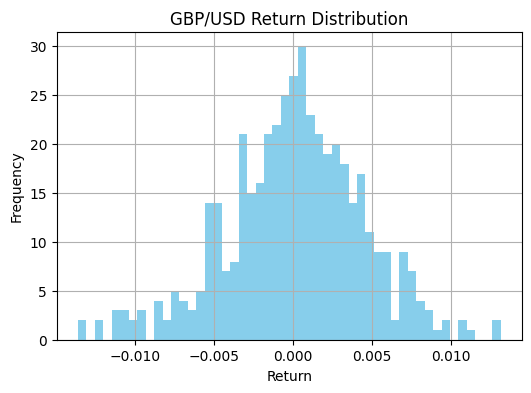

In [64]:
plt.figure(figsize=(6, 4))
df_gbp['Return'].hist(bins=50, color='skyblue')
plt.title('GBP/USD Return Distribution')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


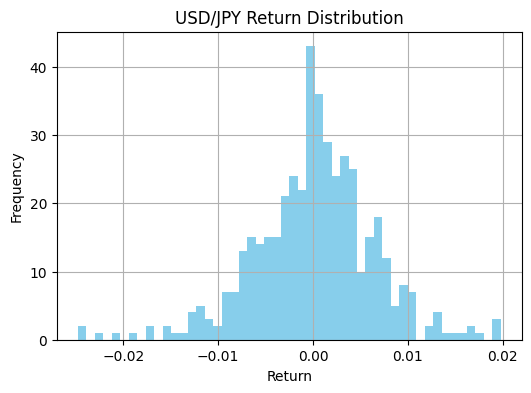

In [65]:
plt.figure(figsize=(6, 4))
df_jpy['Return'].hist(bins=50, color='skyblue')
plt.title('USD/JPY Return Distribution')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Shows skewness, kurtosis, and outliers.Helps validate assumptions for inference.

In [69]:
#Statistical Inference and Hypothesis
#1. Hypothesis: “Volatility is higher during central bank announcement weeks”
# Create a dummy flag for ECB announcement weeks (e.g., every first Thursday of the month)
df_eur['ECB_Week'] = df_eur.index.to_series().apply(lambda x: x.day < 8 and x.weekday() == 3)
# Split data into two groups: event vs non-event. dropna used to clean the data for statistical inference
vol_event = df_eur[df_eur['ECB_Week']]['Volatility'].dropna()
vol_normal = df_eur[~df_eur['ECB_Week']]['Volatility'].dropna()
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(vol_event, vol_normal, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")
#Tests whether the mean volatility differs significantly between the two groups.
#equal_var=False: Welch’s t-test, safer when variances differ.
#Interpretation:
#If p_value < 0.05, the difference is statistically significant.
#You can say: “Volatility is significantly higher during ECB weeks.”

T-statistic: 0.779, P-value: 0.4452


In [70]:
#Hypothesis: “GBP/USD returns are more volatile than EUR/USD”
# Compare standard deviation of returns
std_eur = df_eur['Return'].std()
std_gbp = df_gbp['Return'].std()

print(f"EUR/USD Return Std Dev: {std_eur:.4f}")
print(f"GBP/USD Return Std Dev: {std_gbp:.4f}")
#Compares overall volatility of returns between two pairs.
#You can visualize this with a bar chart or boxplot later.

EUR/USD Return Std Dev: 0.0046
GBP/USD Return Std Dev: 0.0044


In [71]:
#Correlation Between Pairs
# Merge returns into one DataFrame
returns_df = pd.DataFrame({
    'EURUSD': df_eur['Return'],
    'GBPUSD': df_gbp['Return'],
    'USDJPY': df_jpy['Return']
}).dropna()
# Compute correlation matrix
corr_matrix = returns_df.corr()
print(corr_matrix)
#Shows how closely the pairs move together.
#High correlation = similar macro drivers.
#Low correlation = diversification potential.

          EURUSD    GBPUSD    USDJPY
EURUSD  1.000000  0.797951 -0.569781
GBPUSD  0.797951  1.000000 -0.484166
USDJPY -0.569781 -0.484166  1.000000


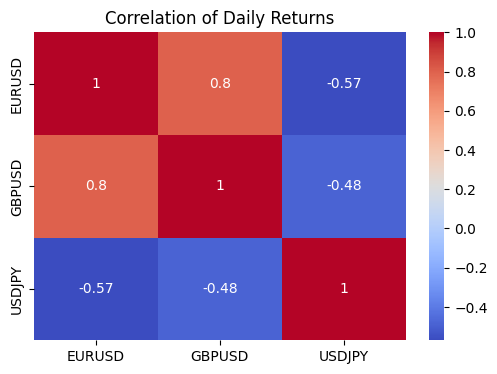

In [73]:
#Visualize Correlation Matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation of Daily Returns")
plt.show()
#Heatmap makes the relationships intuitive.

Plotly Dashboards for all the Forex Pairs.

In [75]:
#The GBP/EUR Dashbard
# Reset index for plotting
df_gbp_plot = df_gbp.reset_index()

# Closing Price
fig_gbp_price = px.line(df_gbp_plot, x='Price', y='Close', title='GBP/USD Daily Closing Price')
fig_gbp_price.update_layout(xaxis_title='Date', yaxis_title='Price', template='plotly_white')
fig_gbp_price.show()

# Rolling Volatility
fig_gbp_vol = px.line(df_gbp_plot, x='Price', y='Volatility', title='GBP/USD 10-Day Rolling Volatility')
fig_gbp_vol.update_layout(xaxis_title='Date', yaxis_title='Volatility', template='plotly_white')
fig_gbp_vol.show()

# Return vs Volatility Scatter
fig_gbp_scatter = px.scatter(
    df_gbp_plot, x='Volatility', y='Return',
    title='GBP/USD Return vs Volatility',
    trendline='ols', color='Return', color_continuous_scale='RdBu'
)
fig_gbp_scatter.update_layout(xaxis_title='Volatility', yaxis_title='Return', template='plotly_white')
fig_gbp_scatter.show()

# Return Distribution Histogram
fig_gbp_hist = px.histogram(
    df_gbp_plot, x='Return', nbins=50,
    title='GBP/USD Daily Return Distribution',
    color_discrete_sequence=['skyblue']
)
fig_gbp_hist.update_layout(xaxis_title='Return', yaxis_title='Frequency', template='plotly_white')
fig_gbp_hist.show()

# KPI Cards
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig_gbp_kpi = make_subplots(rows=1, cols=3, specs=[[{'type':'indicator'}]*3])
fig_gbp_kpi.add_trace(go.Indicator(mode='number', value=df_gbp['Return'].mean(), title={'text': "Avg Daily Return"}, number={'suffix': "%"}), row=1, col=1)
fig_gbp_kpi.add_trace(go.Indicator(mode='number', value=df_gbp['Volatility'].mean(), title={'text': "Avg Volatility"}), row=1, col=2)
fig_gbp_kpi.add_trace(go.Indicator(mode='number', value=df_gbp['Return'].std(), title={'text': "Return Std Dev"}), row=1, col=3)
fig_gbp_kpi.update_layout(title='GBP/USD Performance Summary', template='plotly_white')
fig_gbp_kpi.show()

In [79]:
#The EUR/USD Dashboard
# Reset index for plotting
df_eur_plot = df_eur.reset_index()

# Closing Price
fig_eur_price = px.line(df_eur_plot, x='Price', y='Close', title='EUR/USD Daily Closing Price')
fig_eur_price.update_layout(xaxis_title='Date', yaxis_title='Price', template='plotly_white')
fig_eur_price.show()

# Rolling Volatility
fig_eur_vol = px.line(df_eur_plot, x='Price', y='Volatility', title='EUR/USD 10-Day Rolling Volatility')
fig_eur_vol.update_layout(xaxis_title='Date', yaxis_title='Volatility', template='plotly_white')
fig_eur_vol.show()

# Return vs Volatility Scatter
fig_eur_scatter = px.scatter(
    df_eur_plot, x='Volatility', y='Return',
    title='EUR/USD Return vs Volatility',
    trendline='ols', color='Return', color_continuous_scale='RdBu'
)
fig_eur_scatter.update_layout(xaxis_title='Volatility', yaxis_title='Return', template='plotly_white')
fig_eur_scatter.show()

# Return Distribution Histogram
fig_eur_hist = px.histogram(
    df_eur_plot, x='Return', nbins=50,
    title='EUR/USD Daily Return Distribution',
    color_discrete_sequence=['skyblue']
)
fig_eur_hist.update_layout(xaxis_title='Return', yaxis_title='Frequency', template='plotly_white')
fig_eur_hist.show()

# KPI Cards
fig_eur_kpi = make_subplots(rows=1, cols=3, specs=[[{'type':'indicator'}]*3])
fig_eur_kpi.add_trace(go.Indicator(mode='number', value=df_eur['Return'].mean(), title={'text': "Avg Daily Return"}, number={'suffix': "%"}), row=1, col=1)
fig_eur_kpi.add_trace(go.Indicator(mode='number', value=df_eur['Volatility'].mean(), title={'text': "Avg Volatility"}), row=1, col=2)
fig_eur_kpi.add_trace(go.Indicator(mode='number', value=df_eur['Return'].std(), title={'text': "Return Std Dev"}), row=1, col=3)
fig_eur_kpi.update_layout(title='EUR/USD Performance Summary', template='plotly_white')
fig_eur_kpi.show()


In [81]:
#The USD/JPY Dashboard
# Reset index for plotting
df_jpy_plot = df_jpy.reset_index()

# Closing Price
fig_jpy_price = px.line(df_jpy_plot, x='Price', y='Close', title='USD/JPY Daily Closing Price')
fig_jpy_price.update_layout(xaxis_title='Date', yaxis_title='Price', template='plotly_white')
fig_jpy_price.show()

# Rolling Volatility
fig_jpy_vol = px.line(df_jpy_plot, x='Price', y='Volatility', title='USD/JPY 10-Day Rolling Volatility')
fig_jpy_vol.update_layout(xaxis_title='Date', yaxis_title='Volatility', template='plotly_white')
fig_jpy_vol.show()

# Return vs Volatility Scatter
fig_jpy_scatter = px.scatter(
    df_jpy_plot, x='Volatility', y='Return',
    title='USD/JPY Return vs Volatility',
    trendline='ols', color='Return', color_continuous_scale='RdBu'
)
fig_jpy_scatter.update_layout(xaxis_title='Volatility', yaxis_title='Return', template='plotly_white')
fig_jpy_scatter.show()

# Return Distribution Histogram
fig_jpy_hist = px.histogram(
    df_jpy_plot, x='Return', nbins=50,
    title='USD/JPY Daily Return Distribution',
    color_discrete_sequence=['skyblue']
)
fig_jpy_hist.update_layout(xaxis_title='Return', yaxis_title='Frequency', template='plotly_white')
fig_jpy_hist.show()

# KPI Cards
fig_jpy_kpi = make_subplots(rows=1, cols=3, specs=[[{'type':'indicator'}]*3])
fig_jpy_kpi.add_trace(go.Indicator(mode='number', value=df_jpy['Return'].mean(), title={'text': "Avg Daily Return"}, number={'suffix': "%"}), row=1, col=1)
fig_jpy_kpi.add_trace(go.Indicator(mode='number', value=df_jpy['Volatility'].mean(), title={'text': "Avg Volatility"}), row=1, col=2)
fig_jpy_kpi.add_trace(go.Indicator(mode='number', value=df_jpy['Return'].std(), title={'text': "Return Std Dev"}), row=1, col=3)
fig_jpy_kpi.update_layout(title='USD/JPY Performance Summary', template='plotly_white')
fig_jpy_kpi.show()
